# Introduction to functions and integration
__Content modified under Creative Commons Attribution license CC-BY 4.0,
code under BSD 3-Clause License © 2020 R.C. Cooper__
## Building our own functions.

Functions are saved in memory you can define them with anonymous functions `lambda` and function definitions `def`

Example of storing a function in memory

$f(x,y) = (xy^{3}-x^{3}y)$

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [7]:
f= lambda x,y: (x*y**3-x**3*y)
f(1,0.1)

-0.099

The function, `f(x, y)`=$f(x,~y)$, returns $xy^3-x^3y$. Below, you create a contour plot using 
- `linspace` to define the x-y-axes
- `meshgrid` to fill in each x-y value along each axis, (-1, -1), (-1, -0.99), ...(0.99, 1), (1, 1)
- `contourf` to display the result

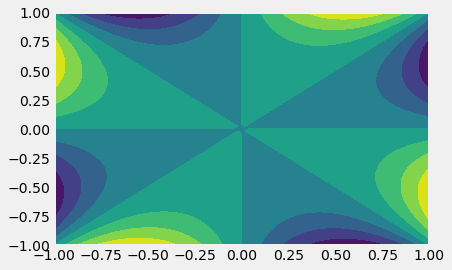

In [8]:
x=np.linspace(-1,1,101); # 10 data points from -1 to 1
y=np.linspace(-1,1,101); # 10 data points from -1 to 1
X,Y=np.meshgrid(x,y); # 100 data points from -1 to 1 on the x- and y-axes
Z=f(X,Y);# Z=f(X,Y) evaluated at the 100 data points

plt.contourf(X,Y,Z) # also pcolor, countour, ...

**For more plotting examples and options check out the [Matplotlib gallery](https://matplotlib.org/gallery/index.html)**

Here, define a function called `my_ode` for a single-DOF forced spring-mass-damper:

$\ddot{x}+2\dot{x}+9x=0.01\cos(2t)$

Its initial postion and velocity are

- $x(0) = 0.1~m$
- $v(0) = 0~m/s$

In order to use a computational method to integrate this differential equation, you have to define a set of first order differential equations. You set these up as such

1. $\frac{dx}{dt} = v(t)$ 
2. $\frac{dv}{dt} = a(t) = -2\dot{x}-9x+0.01\cos(2t)$

Now, you have 2 _first-order_ equations that relate $v~and~a$ to $x~and~v$. You can create a variable called $\mathbf{r}=[x,~v]$ so that

$\frac{d\mathbf{r}}{dt} = f(t, \mathbf{r})$

In [28]:
def my_ode(t, r):
    """ Help documentation for "my_ode"
     input is time, t (s) and r=[position (m); velocity (m/s)] and time
     output is dr=[velocity (m/s); acceleration (m/s/s)] at time, t
     the ODE is defined by:
    
     a = -2*v-9*x+ 0.01*cos(2t)"""
    
    dr=np.zeros(np.size(r))
    dr[0] = r[1]
    dr[1] = -2*r[1]-9*r[0]+0.01*np.cos(2*t);
    return dr

Given any `[position, velocity]` and `time`, the defined `my_ode` returns the velocity and acceleration:

In [29]:
my_ode(0,[1, 2])

array([  2.  , -12.99])

## Euler approximation

The simplest integration routine is the Euler approximation. A first-order Taylor series expansion about the current timestep:

$r_{i+1}=r_{i}+\frac{dr_{i}}{dt}\Delta t$

You can integrate the equation in a `for`-loop. 

> `for`-loop: Is defined in Python by using the function, `for`. You specify the variable, `i`, and the values, `range(1, len(t))` i = (1, 2, ... 100). 

Each step in the loop approximates the next position based upon the current velocity and the next velocity based upon the current acceleration. 

- $x(t+\Delta t) = x(t) + v(t)*\Delta t$ 
- $v(t+\Delta t) = v(t) + a(t)*\Delta t$

In [25]:
N = 100
t = np.linspace(0, 6*np.pi/2, N) # (start, stop, total steps)
dt = t[1] - t[0] # time step
x0 = 0.1
v0 = 0
r = np.zeros((len(t),2))
r[0,:] = np.array([x0,v0])
for i in range(1,len(t)):
    dr = my_ode(t[i-1],r[i-1,:])
    r[i, :] = r[i-1,:] + dr*dt
    

Text(0, 0.5, 'position (m)')

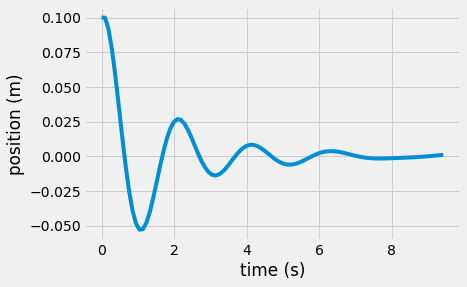

In [26]:
plt.plot(t,r[:,0])
plt.xlabel('time (s)')
plt.ylabel('position (m)')

## Runge-Kutta

Using `solve_ivp` in Python you can use more advanced integration routines, such as [Runge-Kutta 5(4)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#r179348322575-1), [Runge-Kutta 3(2)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#r179348322575-3), [Adams/BDF method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#r179348322575-7), etc. 

Numerical integration algorithms for differential equations:

In [30]:
from scipy.integrate import solve_ivp # import the ordinary differential equation integrator in Python

Text(0, 0.5, 'position (m)')

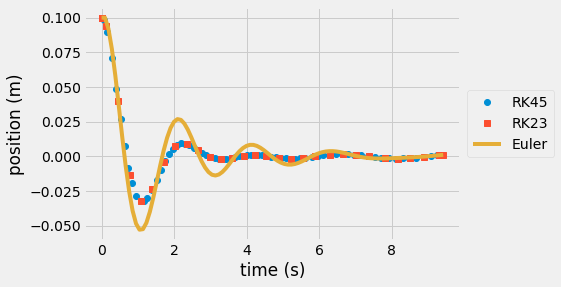

In [31]:

r23=solve_ivp(my_ode,[t[0],t[-1]],[x0, v0],method='RK23');
r45=solve_ivp(my_ode,[t[0],t[-1]],[x0, v0],method='RK45'); # default = 'RK45'
plt.plot(r23.t,r23.y[0],'o',label='RK45')
plt.plot(r45.t,r45.y[0],'s',label='RK23')
plt.plot(t,r[:,0],label='Euler')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#axis([0 10 -0.2 0.3])
plt.xlabel('time (s)')

plt.ylabel('position (m)')

## Freefall Model Computational solution

<img src="./images/freefall.png" style="width: 200px;"/> 

Here is our first computational mechanics model. 

An object falling is subject to the force of 

- gravity ($F_g$=mg) and 
- drag ($F_d=cv^2$)

Acceleration of the object:

$\sum F=ma=F_g-F_d=mg - cv^2 = m\frac{dv}{dt}$

### Define constants and analytical solution (meters-kilogram-sec)

We define parameters for our problem as the acceleration due to gravity, g, drag coefficient, c, and mass of the object, m. Once we have defined these parameters, we have a single variable whose derivative $\frac{dv}{dt}$ is equal to a function of itself $v$ i.e. $\frac{dv}{dt} = f(v,~parameters)$. 

**parameters:**

g=9.81 m/s$^2$, c=0.25 kg/m, m=60 kg

**function:**

$\frac{dv}{dt} = g-\frac{c}{m}v^2$

We can solve for the analytical solution in this case. First, consider the speed of the falling object when acceleration is $\frac{dv}{dt}=0$, this is called the terminal velocity, $v_{terminal}$.  

$v_{terminal}=\sqrt{\frac{mg}{c}}$

Now, substitute this terminal velocity into the equation and integrate to get the analytical solution v(t):

$v(t)=v_{terminal}\tanh{\left(\frac{gt}{v_{terminal}}\right)}$. 

## Exercise:

Calculate the terminal velocity for the given parameters, g=9.81 m/s$^2$, c=0.25 kg/m, m=60 kg.

In [34]:
c=0.25 
m=60
g=9.81 


def v_analytical(t, m = m, g = g, c = c):
    '''Analytical solution for the velocity of an object released from rest subject to 
    the force of gravity and the force of drag with drag coefficient, c
    
    Arguments 
    ---------
    t: time, the independent variable
    m: mass of the object
    g: acceleration due to gravity
    c: drag coefficient
    
    Returns
    -------
    v: the speed of the object at time t'''
    
    v_terminal=np.sqrt(m*g/c)
    v= v_terminal*np.tanh(g*t/v_terminal)
    return v

Inside the curly brackets—the placeholders for the values we want to print—the `f` is for `float` and the `.4` is for four digits after the decimal dot. The colon here marks the beginning of the format specification (as there are options that can be passed before). There are so many tricks to Python's string formatter that you'll usually look up just what you need.
Another useful resource for string formatting is the [Python String Format Cookbook](https://mkaz.blog/code/python-string-format-cookbook/). Check it out!

Printing these values using the string formatter,  with a total length of `5` and only printing 2 decimal digits, we can display our solution in a human-readable way.

```python
{:5.2f}
```
where 

- `:5` prints something with whitespace that is 5 spaces total
- `.2` prints 2 significant figures after the decimal
- `f` tells `format` that the input is a floating point number to print


## Analytical vs Computational Solution

The analytical solution above gives us an exact function for $v(t)$. We can input any time, `t`, and calculate the speed, `v`.

In many engineering problems, we cannot find or may not need an exact mathematical formula for our design process. It is always helpful to compare a computational solution to an analytical solution, because it will tell us if our computational solution is correct. Next, we will develop the **Euler approximation** to solve the same problem.

## Define numerical method
### Finite difference approximation

Computational models do not solve for functions e.g. v(t), but rather functions at given points in time (or space). In the given freefall example, we can approximate the derivative of speed, the speed at the next poitn in time given the current time and its current speed as such

In [60]:
c=0.25 
m=60
g=9.81 


def freefall_acceleration(t, v, m = m, g = g, c = c):
    '''Analytical solution for the velocity of an object released from rest subject to 
    the force of gravity and the force of drag with drag coefficient, c
    
    Arguments 
    ---------
    t: time, the independent variable
    m: mass of the object
    g: acceleration due to gravity
    c: drag coefficient
    
    Returns
    -------
    a: the acceleratio of the object at time t given speed v'''
    
    a = g - c/m*v**2
    return a

### Compare solutions (plotting)

We can compare solutions in a figure in a number of ways:

1. plot the values, e.g. $v_{analytical}$ and $v_{numerical}$

2. plot the difference between the values (the absolute error) e.g. $v_{numerical}-v_{analytical}$

3. plot the ratio of the values e.g. $\frac{v_{numerical}}{v_{analytical}}$ (useful in finding bugs, unit analysis, etc.)

4. plot the ratio of the error to the best estimate (the relative error) e.g. $\frac{v_{numerical}-v_{analytical}}{v_{analytical}}$

Let's start with method (1) to compare our analytical and computational solutions.

Import `pyplot` and update the default plotting parameters.

In [70]:
t = np.linspace(0, 6, 7)
v_numerical = solve_ivp(freefall_acceleration, 
                        [0, t.max()], # start time = 0s end time = 6 s
                        np.array([0]), # initial speed is 0 m/s
                        t_eval = t) # evaluate at timesteps in t
v_numerical

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 44
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0., 1., 2., 3., 4., 5., 6.])
 t_events: None
        y: array([[ 0.        ,  9.6784823 , 18.60812648, 26.27885144, 32.46529288,
        37.17842896, 40.64293497]])
 y_events: None

Text(0, 0.5, 'velocity (m/s)')

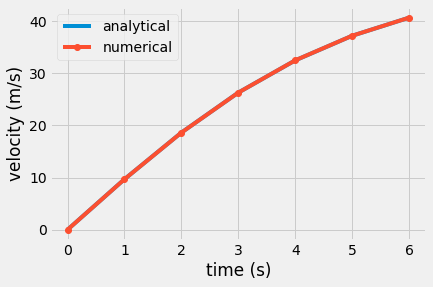

In [71]:
plt.plot(t,v_analytical(t),'-',label='analytical')
plt.plot(v_numerical.t ,v_numerical.y[0],'o-',label='numerical')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')

**Note:** In the above plot, the numerical solution is given at discrete points connected by lines, while the analytical solution is drawn as a line. This is a helpful convention. We plot discrete data such as numerical solutions or measured data as points and lines while analytical solutions are drawn as lines. 


Text(0.5, 1.0, 'error in numerical result')

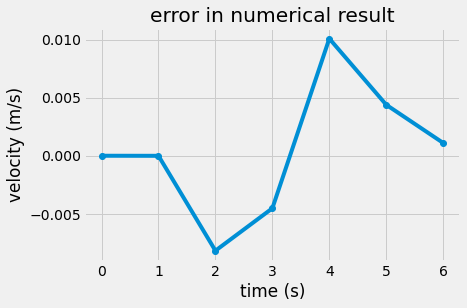

In [72]:
plt.plot(v_numerical.t ,
         v_numerical.y[0] - v_analytical(t),
         'o-',label='numerical')

plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.title('error in numerical result')

__Note__: In the above plot, the error is calculated as a difference between numerical and analytical result. Try changing the y axis to a relative error using the formula

$relative~error = \frac{|v_{numerical} - v_{analytical}|}{|v_analytical|}$

## What you've learned

* Numerical integration with the Euler approximation and `solve_ivp`
* How to time a numerical solution or a function
* How to compare solutions